# TRUSTWORTHY AI: Technical robustness and safety Requirement

#### Script to ensure the Robustness and safety requirement for a dataset. Based on EU guidelines.
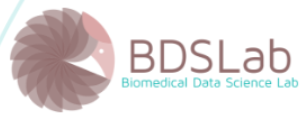


## TABLE OF CONTENTS:

<div class="alert" style="margin-top: 20px">

1. [Data preparation](#data-preparation)<br>
1.1. [Data pre-processing](#data-pre-processing)<br>
1.2. [Data quality control](#data-quality-control)<br>

2. [Model Development](#model-development)<br>
2.1. [Design & Training](#design-training)<br>
2.2. [Evaluation](#evaluation)<br>

3. [Deployment & Use](#deployment-use)<br>


[References](#references)
</div>


The key requirement of Technical robustness and safety covers four main concepts:

* **Resilience to attack and security:** protect against vulnerabilities that can be exploited by adversaries.
*  **Fallback plan and general safety:** safeguards to minimise errors.
*  **Accuracy:** make juices properly. If inaccuracies cannot be avoided, indicate the probability of occurrence.
*  **Realiability and reproducibility:** ensure that the IA works properly within an interval and is able to maintain its behaviour under the same conditions.

We start by preparing the working environment. Import all the necessary libraries.

In [70]:
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.subplots as sp
import json

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.calibration import calibration_curve
from sklearn.utils import resample

from imblearn.over_sampling import SMOTENC

from functions.NaiveBayesMixed import NaiveBayesMixed
from functions.handleData import handleData

Load the dataset and define Metadata

In [71]:
path = 'C:\\Users\\carlo\\OneDrive - UPV\\ESCRITORIO CARLOS\\UPV\\BECA COLABORACIÓN\\Datasets\\Heart Disease\\' 
file_name = 'dataset_train_QC.csv'
data = pd.read_csv(path + file_name)

# Create a subset to work more efficiently
# data = data.sample(frac = 0.3, random_state=100) 

In [72]:
# Load metadata from the JSON file
file_name = 'metadata_QC.json'
with open(path + file_name, 'r') as json_file:
    metadata = json.load(json_file)

# Assign variables from loaded metadata
dataset = data
output = metadata["output"]
positive_class = metadata["positive_class"]

In [73]:
# ### Uncomment only if you want to binarise a multi-class classification problem ###
if positive_class:
    dataset[output] = pd.Series(np.where(dataset[output] == positive_class, 1, 0), index=dataset[output].index, name=output)

features_df = dataset.drop(output,axis=1)
tags_df = dataset[output] 

unique_classes = np.unique(tags_df)
n_classes = len(unique_classes)
feat_num = [key for key, value in metadata["feat_types"].items() if value == "numerical"]
feat_cat = [key for key, value in metadata["feat_types"].items() if value == "categorical"]
feature_names = features_df.columns

handleData = handleData(feat_num, feat_cat)

## 1. DATA PREPARATION  <a class="anchor" id="data-preparation"></a>

### 1.1. Data Pre-processing: <a class="anchor" id="data-pre-processing"></a>

To deal with the curse of dimensionality it would be useful to implement a `Feature selection or Dimension reduction` step [1].

### 1.2. Data Quality Control: <a class="anchor" id="data-quality-control"></a>

If your classes are unbalaced, you can use `Class balancing` methods such as oversampling or downsampling [2]. In our case, we will use SMOTENC during the training to balance the classes.

## 2. MODEL DEVELOPMENT <a class="anchor" id="model-development"></a>
### 2.1. Design & Training  <a class="anchor" id="design-training"></a>

In [74]:
features_df_encoded, features_names_encoded, feat_cat_encoded = handleData.encode(features_df)
feat_train, feat_test, tags_train, tags_test = train_test_split(features_df_encoded, tags_df, test_size=0.2, random_state = 1)

In [75]:
model_RandomForest = RandomForestClassifier(random_state=1)
model_MixedNB = NaiveBayesMixed(feat_num, feat_cat_encoded)

classifiers = {'RF': model_RandomForest, 'NB': model_MixedNB}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'purple', 'brown', 'pink', 'gray']



A `Well-formed evaluation` is required, which would include cross-validation (CV) [3], cost functions and robust metrics. Before training the full model, you can search for better parameters of the model with a `Hyperparameter Optimization` step. In particular, we use GridSearch [4] within CV to optimize Random Forest hyperparameters. Ideally, GridSearch would include an oversampling step within its loop. However, due to its complexity, we fit the GridSearch CV with oversampled data. If you have enough data, you can use this approach with Hold Out.

In [76]:
youden_index_cutoff = {classifier_name: [] for classifier_name in classifiers.keys()}
trained_models = {classifier_name: [] for classifier_name in classifiers.keys()}
best_params_all = {classifier_name: [] for classifier_name in classifiers.keys()}

# Define the parameter grids
param_grid = {
    'RF': {
        'n_estimators': [50, 100, 150], 
        'max_depth': [5, 15, 30, 45],  
    },
    'NB': {
        'feat_num': [feat_num],
        'feat_cat': [feat_cat_encoded],
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-5],
        'alpha': [0.1, 0.25, 0.5, 1.0]
    }
}

Average best parameters for RF: {'max_depth': 20.0, 'n_estimators': 137.5}
Average best parameters for NB: {'alpha': 0.1, 'feat_cat': ['sex_female', 'sex_male', 'chest_pain_type_asymptomatic', 'chest_pain_type_atypical angina', 'chest_pain_type_non-anginal pain', 'chest_pain_type_typical angina', 'fasting_blood_sugar_0', 'fasting_blood_sugar_1', 'resting_ecg_LV hypertrophy', 'resting_ecg_ST-T abnormality', 'resting_ecg_normal', 'exercise_angina_0', 'exercise_angina_1', 'ST_slope_downsloping', 'ST_slope_flat', 'ST_slope_upsloping'], 'feat_num': ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak'], 'var_smoothing': 1e-09}


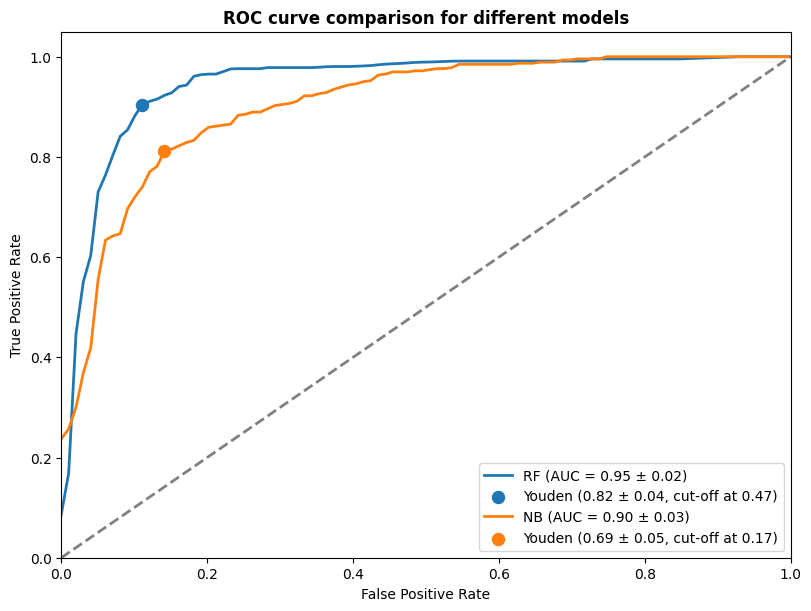

In [77]:
skf = StratifiedKFold(n_splits=4)
smotenc = SMOTENC(categorical_features=feat_cat, random_state=1)
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))
for i, (classifier_name, classifier) in enumerate(classifiers.items()):
    color = colors[i % len(colors)]

    youden_indexes = []
    thresholds_youden = []
    auc_folds = []
    tpr_folds = []

    for train_index, test_index in skf.split(feat_train, tags_train):
        X_train, X_test = feat_train.iloc[train_index], feat_train.iloc[test_index]
        y_train, y_test = tags_train.iloc[train_index], tags_train.iloc[test_index]

        X_train_decoded = handleData.decode(X_train)
        X_train_over_decoded, y_train_over = smotenc.fit_resample(X_train_decoded, y_train)
        X_train_over, _, _ = handleData.encode(X_train_over_decoded)

        # Hyperparameter tuning
        grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=2, scoring='roc_auc')
        grid_search.fit(X_train_over, y_train_over)
        classifiers[classifier_name] = grid_search.best_estimator_
        best_params_all[classifier_name].append(grid_search.best_params_)

        # Train the best estimator
        classifier.fit(X_train_over, y_train_over)
        y_pred_prob = classifier.predict_proba(X_test)

        # Calculate ROC and Youden index
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
        tpr_folds.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        auc_folds.append(roc_auc)

        youden_value = tpr - fpr
        youden_fold = youden_value.max()
        youden_threshold = thresholds[np.argmax(youden_value)]
        youden_indexes.append(youden_fold)
        thresholds_youden.append(youden_threshold)
    

    # Display average best parameters for each classifier
    avg_best_params = {}
    for param in best_params_all[classifier_name][0].keys():
        if isinstance(best_params_all[classifier_name][0][param], (int, float)):
            avg_best_params[param] = np.mean([params[param] for params in best_params_all[classifier_name]])
        else:
            avg_best_params[param] = best_params_all[classifier_name][0][param]  # Solo tomar el primer valor ya que son listas
    print(f"Average best parameters for {classifier_name}: {avg_best_params}")

    mean_tpr = np.mean(tpr_folds, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_std = np.std(auc_folds)

    avg_youden = np.mean(youden_indexes)
    std_youden = np.std(youden_indexes)
    avg_threshold = np.mean(thresholds_youden)
    youden_index_cutoff[classifier_name] = avg_threshold
   
    plt.plot(mean_fpr, mean_tpr, color=color, lw=2, label=f'{classifier_name} (AUC = {mean_auc:.2f} ± {auc_std:.2f})')
    plt.scatter(mean_fpr[np.argmax(mean_tpr - mean_fpr)], mean_tpr[np.argmax(mean_tpr - mean_fpr)], color=color, marker='o', s=75, label=f'Youden ({avg_youden:.2f} ± {std_youden:.2f}, cut-off at {avg_threshold:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontdict={'fontsize':10})
plt.ylabel('True Positive Rate', fontdict={'fontsize':10})
plt.title('ROC curve comparison for different models', fontdict={'fontsize':12, 'weight': 'bold'})
plt.legend(loc="lower right", prop={'size':10})
sns.set_palette('colorblind')
plt.show()


### 2.2. Evaluation  <a class="anchor" id="evaluation"></a>

Once cross-validation is done with the training subset, we can do its validation with the test subset.

Final model evaluation for RF on test set:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       111
           1       0.89      0.95      0.92       103

    accuracy                           0.92       214
   macro avg       0.92      0.92      0.92       214
weighted avg       0.92      0.92      0.92       214

Final model evaluation for NB on test set:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       111
           1       0.80      0.87      0.83       103

    accuracy                           0.83       214
   macro avg       0.83      0.83      0.83       214
weighted avg       0.84      0.83      0.83       214



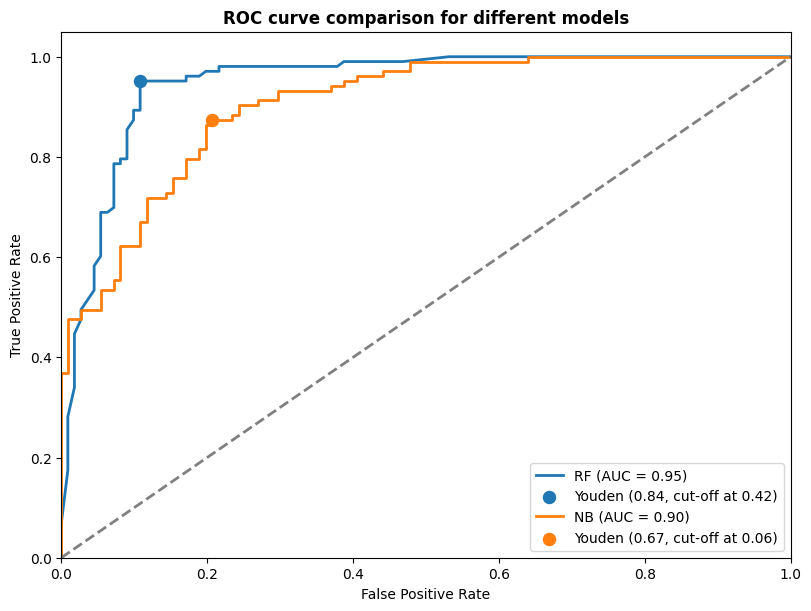

In [78]:
plt.figure(figsize=(8, 6))


for i, (classifier_name, classifier) in enumerate(classifiers.items()):
    color = colors[i % len(colors)]
    
    classifier.fit(feat_train, tags_train)
    proba_pred = classifier.predict_proba(feat_test)
    
    fpr, tpr, thresholds = roc_curve(tags_test, proba_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Calcular el índice de Youden
    youden_values = tpr - fpr
    max_index = np.argmax(youden_values)
    best_threshold = thresholds[max_index]
    best_youden = youden_values[max_index]
    youden_index_cutoff[classifier_name] = best_threshold
    
    # Graficar la curva ROC
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{classifier_name} (AUC = {roc_auc:.2f})')
    
    # Graficar el punto correspondiente al índice de Youden
    plt.scatter(fpr[max_index], tpr[max_index], color=color, marker='o', s=75, label=f'Youden ({best_youden:.2f}, cut-off at {best_threshold:.2f})')

    # Predecir las etiquetas utilizando el umbral del índice de Youden
    tags_pred = np.where(proba_pred[:, 1] >= best_threshold, 1, 0)
    print(f"Final model evaluation for {classifier_name} on test set:")
    print(classification_report(tags_test, tags_pred))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontdict={'fontsize':10})
plt.ylabel('True Positive Rate', fontdict={'fontsize':10})
plt.title('ROC curve comparison for different models', fontdict={'fontsize':12, 'weight': 'bold'})
plt.legend(loc="lower right", prop={'size':10})
sns.set_palette('colorblind')
plt.show()


To quantify the consistency of your model you must include an `Uncertainty quantification in metrics`. Using bootstrap methods you can train differents models and offer a confidence interval help quantify the certainty of your metrics.

In [79]:
# Define Bootstrap parameters
classifiers_bootstrap = {
    'RF': RandomForestClassifier(),
    'NB': NaiveBayesMixed(feat_num, feat_cat_encoded)
}

n_bootstraps = 10
trained_models_BT = {classifier_name: [] for classifier_name in classifiers.keys()}

In [80]:
# Bootstrap resampling
for classifier_name, classifier in classifiers_bootstrap.items():

    sensitivity_scores = []
    specificity_scores = []
    f1_scores = []

    # Generate random parameter choices
    random_param_grid = {
        'RF': {
            'n_estimators': np.random.choice(param_grid['RF']['n_estimators']), 
            'max_depth': np.random.choice(param_grid['RF']['max_depth']),  
        },
        'NB': {
            'feat_num': feat_num,
            'feat_cat': feat_cat_encoded,
            'var_smoothing': np.random.choice(param_grid['NB']['var_smoothing']),
            'alpha': np.random.choice(param_grid['NB']['alpha'])
        }
    }

    # Create a new instance of the classifier for each bootstrap iteration
    if classifier_name == 'RF':
        classifier_instance = RandomForestClassifier()
    elif classifier_name == 'NB':
        classifier_instance = NaiveBayesMixed(feat_num, feat_cat_encoded)
    classifier_instance.set_params(**random_param_grid[classifier_name])

    # classifier.set_params(**random_param_grid[classifier_name])

    for boot in range(n_bootstraps):

        # Generate bootstrap sample
        feat_train_resampled, tags_train_resampled = resample(feat_train, tags_train, n_samples=int(len(feat_train)/(n_bootstraps)), replace=True, random_state=boot)
        classifier_instance.fit(feat_train_resampled, tags_train_resampled)
        proba_pred = classifier_instance.predict_proba(feat_test)
        tags_pred = np.where(proba_pred[:, 1] >= youden_index_cutoff[classifier_name], 1, 0)
       
        TN, FP, FN, TP = confusion_matrix(tags_test, tags_pred).ravel()

        
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        f1_result = f1_score(tags_test, tags_pred, average='weighted') 
        
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)
        f1_scores.append(f1_result)
        trained_models_BT[classifier_name].append(classifier_instance)

    print(f"Bootstrap Resampling Results for {classifier_name}:")
    print(f"- Mean Sensitivity: {np.mean(sensitivity_scores) * 100:.2f}%, Std Sensitivity: {np.std(sensitivity_scores) * 100:.2f}%")
    print(f"- Mean Specificity: {np.mean(specificity_scores) * 100:.2f}%, Std Specificity: {np.std(specificity_scores)  * 100:.2f}%")
    print(f"- Mean F1-score: {np.mean(f1_scores) * 100:.2f}%, Std F1-score: {np.std(f1_scores)* 100:.2f}% \n")

Bootstrap Resampling Results for RF:
- Mean Sensitivity: 87.09%, Std Sensitivity: 5.01%
- Mean Specificity: 72.43%, Std Specificity: 5.32%
- Mean F1-score: 79.36%, Std F1-score: 1.85% 

Bootstrap Resampling Results for NB:
- Mean Sensitivity: 84.95%, Std Sensitivity: 3.59%
- Mean Specificity: 76.49%, Std Specificity: 2.50%
- Mean F1-score: 80.54%, Std F1-score: 1.73% 



A calibration curve might also provide some useful information.

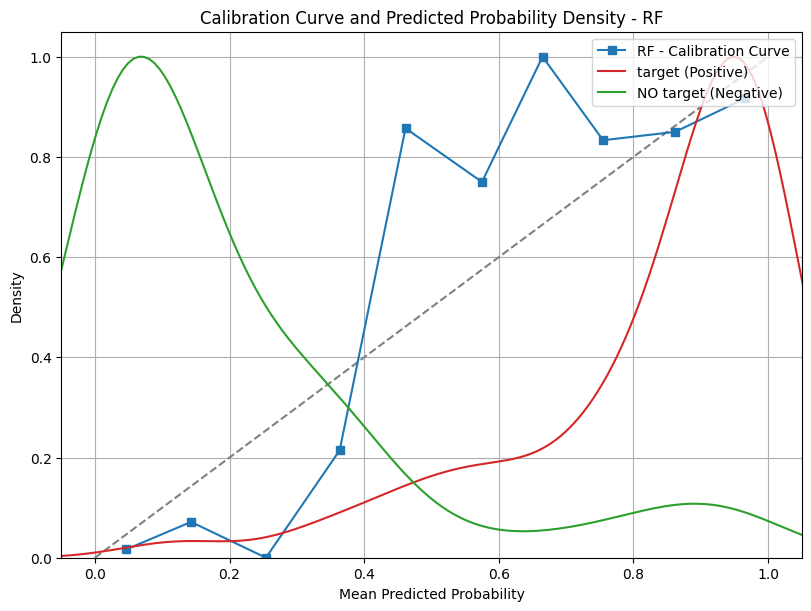

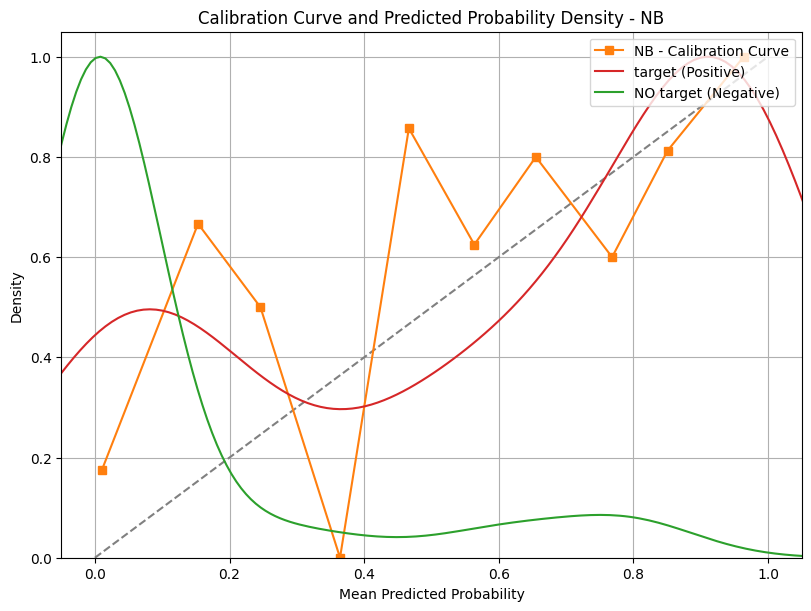

In [81]:
for i, (classifier_name, classifier) in enumerate(classifiers.items()):
    color = colors[i % len(colors)]

    plt.figure(figsize=(8, 6))

    # Obtain predicted probabilities
    prob_pos = classifier.predict_proba(feat_test)[:,1]
    fraction_of_positives, mean_predicted_value = calibration_curve(tags_test, prob_pos, n_bins=10)

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.plot(mean_predicted_value, fraction_of_positives, marker='s', color=color, linestyle='-', label=f'{classifier_name} - Calibration Curve')

    # Density plot for positive and negative predictions
    sns.kdeplot(prob_pos[tags_test == 1], color=colors[3], label=f'{output} (Positive)', linestyle='-')
    sns.kdeplot(prob_pos[tags_test == 0], color=colors[2], label=f'NO {output} (Negative)', linestyle='-')
    
    # Normalize the KDE
    plt.gca().get_lines()[-2].set_ydata(plt.gca().get_lines()[-2].get_ydata() / plt.gca().get_lines()[-2].get_ydata().max())
    plt.gca().get_lines()[-1].set_ydata(plt.gca().get_lines()[-1].get_ydata() / plt.gca().get_lines()[-1].get_ydata().max())

    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'Calibration Curve and Predicted Probability Density - {classifier_name}')
    plt.grid(True)
    plt.legend(fontsize='medium', loc='upper right')
    plt.xlim(-0.05, 1.05)
    plt.ylim(0, 1.05)
    sns.set_palette('colorblind')
    plt.show()


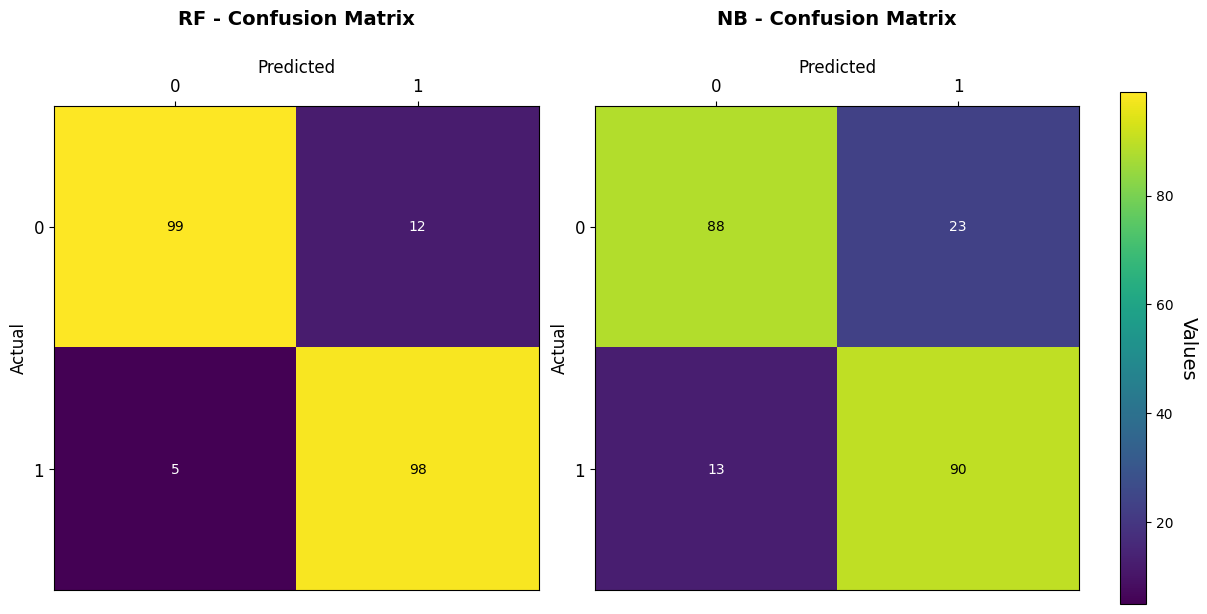

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plt.rcParams['figure.constrained_layout.use'] = True

vmin = np.inf
vmax = -np.inf
ims = []

for i, (classifier_name, classifier) in enumerate(classifiers.items()):

    proba_pred = classifier.predict_proba(feat_test)
    tags_pred = np.where(proba_pred[:, 1] >= youden_index_cutoff[classifier_name], 1, 0)
    conf_matrix = confusion_matrix(tags_test, tags_pred, labels=unique_classes)

    vmin = min(vmin, conf_matrix.min())
    vmax = max(vmax, conf_matrix.max())

    im = axs[i].imshow(conf_matrix, cmap='viridis')
    ims.append(im)
    
    threshold = np.max(conf_matrix) / 2

    # Loop over data dimensions to adapt text annotations
    for j in range(len(unique_classes)):
        for k in range(len(unique_classes)):
            color = "black" if round(conf_matrix[j, k], 2) > threshold else "white"
            axs[i].text(k, j, round(conf_matrix[j, k], 2), ha="center", va="center", color=color)

    axs[i].set_xticks(np.arange(len(unique_classes)))
    axs[i].set_yticks(np.arange(len(unique_classes)))
    axs[i].set_xticklabels(unique_classes, fontdict={'fontsize': 12})
    axs[i].set_yticklabels(unique_classes, fontdict={'fontsize': 12})
    axs[i].set_title(f"{classifier_name} - Confusion Matrix", fontdict={'fontsize': 14, 'weight': 'bold'}, y=1.15)
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axs[i].set_ylabel("Actual", fontdict={'fontsize': 12})
    axs[i].set_xlabel("Predicted", fontdict={'fontsize': 12})

# Update all imshow objects with the same vmin and vmax
for im in ims:
    im.set_clim(vmin, vmax)

# Add a single colorbar for all subplots
cbar = fig.colorbar(ims[0], ax=axs, fraction=0.046, pad=0.04)
cbar.set_label('Values', rotation=-90, va="bottom", fontsize=14)

# Invert X axis labels
for ax in axs:
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

plt.show()


## 3. DEPLOYMENT & USE <a class="anchor" id="deployment-use"></a>

In [83]:
file_name = 'dataset_test_QC.csv'
data_test = pd.read_csv(path + file_name)

feat_test = data_test.drop(output,axis=1)
feat_test, _, _ = handleData.encode(feat_test)
tags_test = pd.Series(np.where(data_test[output] == positive_class, 1, 0), index=data_test[output].index, name=output)

feat_train = features_df_encoded
tags_train = tags_df

for classifier_name, classifier in classifiers.items():    
    classifier.fit(feat_train, tags_train)

It is important to consider `Uncertainty quantification` methods [5]. We offer two insights: evaluating consistency between models for the same sample (Bayesian) and in a model for a perturbed sample (Augmentation). In order to ensure `General safety`, in the event of considerable uncertainty, such as in the case of the saturation threshold falling within the confidence interval, it is inadvisable to make any predictions.

#### Bayesian

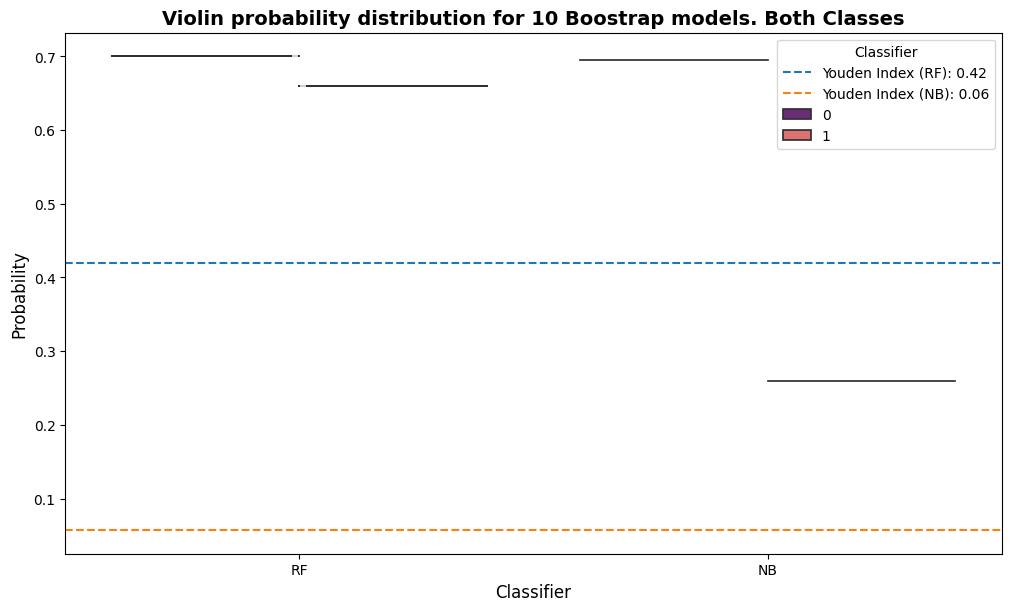

In [84]:
random_samples = handleData.get_random_samples(feat_test, tags_test)

probabilities = []
classifier_name_concat = []
samples = []

plt.figure(figsize=(10, 6))

for i, (classifier_name, model_info) in enumerate(trained_models_BT.items()):
    color = colors[i % len(colors)]

    for model in model_info:
        for tag, rdm_feat in random_samples.items():
            prob = model.predict_proba(rdm_feat)[:, 1]
            probabilities.extend(prob)
            classifier_name_concat.extend([classifier_name] * len(prob))
            samples.extend([tag] * len(prob))

    plt.axhline(y=youden_index_cutoff[classifier_name], color=color, linestyle='--', label=f'Youden Index ({classifier_name}): {youden_index_cutoff[classifier_name]:.2f}')

probabilities_df = pd.DataFrame({'Sample': samples, 'Classifier': classifier_name_concat, 'Probability': probabilities})

sns.violinplot(x='Classifier', y='Probability', hue='Sample', data=probabilities_df, split=True, palette='magma')
plt.title(f'Violin probability distribution for {n_bootstraps} Boostrap models. Both Classes', fontdict={'fontsize': 14, 'weight': 'bold'})
plt.ylabel('Probability', fontdict={'fontsize': 12})
plt.xlabel('Classifier', fontdict={'fontsize': 12})
plt.legend(title='Classifier', loc='upper right')
sns.set_palette('colorblind')
plt.show()

#### Augmentation
We use this method to estimate a 95% confidence interval. If the Youden index is within the CI threshold, the classification may be inaccurate.

In [85]:
model_name = 'RF' # Choose a model name

Classification Report Class 1:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.98      0.99       100

    accuracy                           0.98       100
   macro avg       0.50      0.99      0.49       100
weighted avg       1.00      0.98      0.99       100



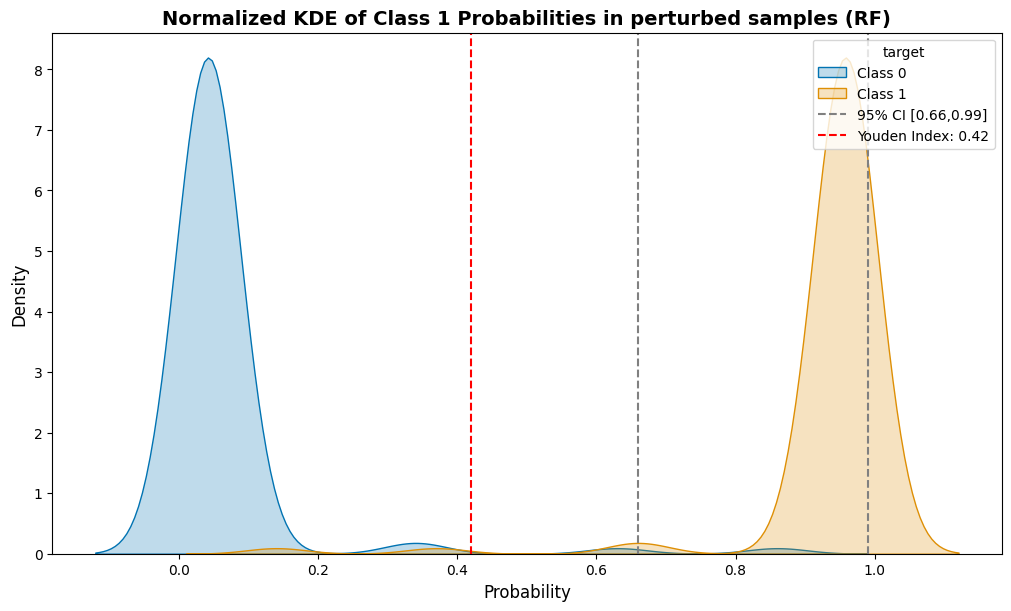

Classification Report Class 0:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       0.00      1.00      0.00         0

    accuracy                           0.98       100
   macro avg       0.50      0.99      0.49       100
weighted avg       1.00      0.98      0.99       100



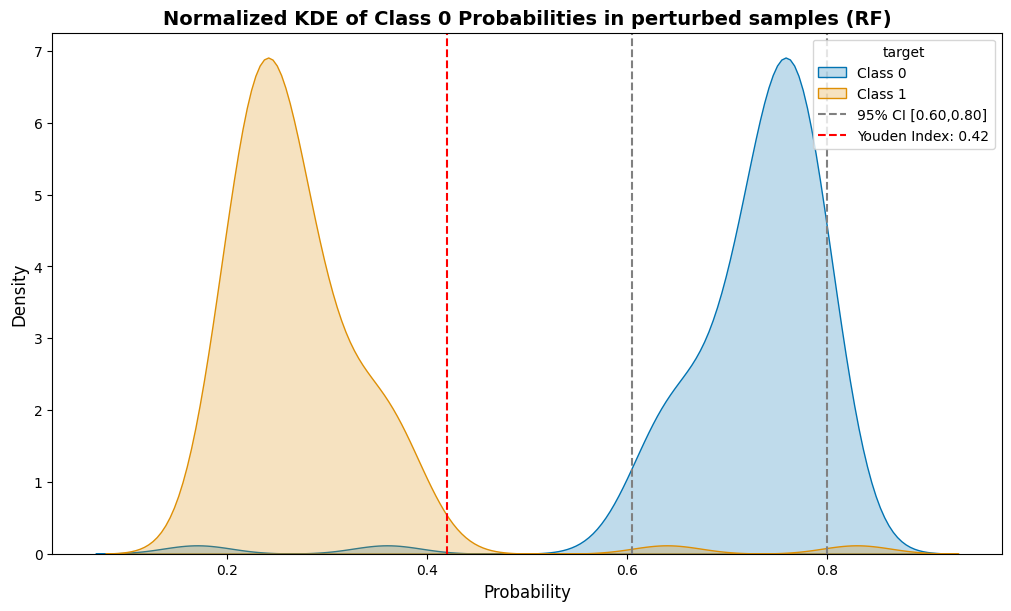

In [86]:
times = 100
for tag, rdm_feat in random_samples.items():

    # Obtain perturbed samples, encode and add missing categories
    sample_augmentation = handleData.decode(rdm_feat)
    augmented_samples = handleData.perturb_sample(sample_augmentation.iloc[0,:], features_df, times)
    augmented_samples_enc, _, _ = handleData.encode(augmented_samples)
    augmented_samples_enc = handleData.adjust_categories(augmented_samples_enc, features_names_encoded)

    proba_pred = classifiers[model_name].predict_proba(augmented_samples_enc)
    tags_pred = np.where(proba_pred[:, 1] >= youden_index_cutoff[model_name], 1, 0)
    tags_augmented = np.repeat(tag, 100)  # Repeat label for each perturbed sample
    print(f"Classification Report Class {tag}:\n", classification_report(tags_augmented, tags_pred, zero_division=1))

    # Obtain probabilities per class
    class_probabilities = [[] for _ in range(len(classifiers[model_name].classes_))] 
    for prob in proba_pred:
        for i, p in enumerate(prob):
            class_probabilities[i].append(p)

    # Plot KDE
    plt.figure(figsize=(10, 6))
    for i, class_prob in enumerate(class_probabilities):
        sns.kdeplot(class_prob, label=f'Class {classifiers[model_name].classes_[i]}', fill=True, common_norm=True)

    # Calculate percentiles 2.5 and 97.5
    percentile_2_5 = np.percentile(class_probabilities[tag], 2.5)
    percentile_97_5 = np.percentile(class_probabilities[tag], 97.5)

    # Plot percentile
    plt.axvline(x=percentile_2_5, color='gray', linestyle='--', label=f'95% CI [{percentile_2_5:.2f},{percentile_97_5:.2f}]')
    plt.axvline(x=percentile_97_5, color='gray', linestyle='--')

    # Plot Youden index
    plt.axvline(x=youden_index_cutoff[model_name], color='red', linestyle='--', label=f'Youden Index: {youden_index_cutoff[model_name]:.2f}')

    plt.title(f'Normalized KDE of Class {tag} Probabilities in perturbed samples ({model_name})', fontdict={'fontsize': 14, 'weight': 'bold'})
    plt.xlabel('Probability', fontdict={'fontsize': 12})
    plt.ylabel('Density', fontdict={'fontsize': 12})
    plt.legend(title=output, loc='upper right')
    sns.set_palette('colorblind')
    plt.show()


You can also evaluate the consistency with the outliers identified during data preparation. 

In [87]:
try:
    file_name = 'outliers_multivariate.csv'
    outliers = pd.read_csv(path + file_name)

    # Binarize output and separate into features and tags
    outliers[output] = pd.Series(np.where(outliers[output] == positive_class, 1, 0), index=outliers[output].index, name=output)
    feat_outliers = outliers.drop(output,axis=1)
    feat_outliers_encoded, _, _ = handleData.encode(feat_outliers)
    feat_outliers_encoded = handleData.adjust_categories(feat_outliers_encoded, features_names_encoded)

    tags_outliers = outliers[output]


    proba_pred = classifiers[model_name].predict_proba(feat_outliers_encoded)
    tags_pred = np.where(proba_pred[:, 1] >= youden_index_cutoff[model_name], 1, 0)

    print(f"Classification Report {model_name} in outliers:\n", classification_report(tags_outliers, tags_pred, zero_division=1))

except:
    print("There are no multivariate outliers")

There are no multivariate outliers


An intriguing approach would be to contrast both Bayesian and augmentation methodologies with outlier and normal data.

In [88]:
try:
    for single_class in unique_classes:

        # Filter data to include only those with label 1
        positive_outliers = tags_outliers[tags_outliers == single_class].index
        positive_test = tags_test[tags_test == single_class].index

        # Determine number of samples for filtering and rows
        number_of_samples = int(n_bootstraps / 2)
        outlier_rows = positive_outliers[:number_of_samples]
        test_rows = positive_test[:number_of_samples]

        # Concatenate labels and features
        tags_outlier_and_test = pd.concat([tags_outliers.loc[outlier_rows], tags_test.loc[test_rows]])
        feat_outlier_and_test = pd.concat([feat_outliers_encoded.loc[outlier_rows], feat_test.loc[test_rows]])

        # Generate X labels
        x_label = [f"Outlier {i}" for i in range(1, number_of_samples + 1)]
        x_label.extend([f"Normal {i}" for i in range(1, number_of_samples + 1)])

        probabilities_bootstrap = pd.DataFrame()
        probabilities_augmentation = pd.DataFrame()

        # Predict probabilities for BOOTSTRAP METHOD
        for i, model in enumerate(trained_models_BT[model_name]):
            prob_pred = model.predict_proba(feat_outlier_and_test)[:, 1]
            probabilities_bootstrap[f'Sample {i+1}'] = prob_pred
        probabilities_bootstrap['Case'] = x_label
        probabilities_bootstrap_melted = pd.melt(probabilities_bootstrap, id_vars=['Case'], var_name='Model', value_name='Probability')

        # Predict probabilities for DATA AUGMENTATION METHOD
        for i in range(len(feat_outlier_and_test)):
            features = feat_outlier_and_test.iloc[i:i+1]  # Select the row as a DataFrame

            # Obtain perturbed samples, encode, and adjust categories
            features_augmentation = handleData.decode(features)
            features_augmentation = handleData.perturb_sample(features_augmentation.iloc[0, :], features_df, n_bootstraps)
            features_augmentation_enc, _, _ = handleData.encode(features_augmentation)
            features_augmentation_enc = handleData.adjust_categories(features_augmentation_enc, features_names_encoded)

            prob_pred = classifiers[model_name].predict_proba(features_augmentation_enc)[:, 1]
            probabilities_augmentation[f'Sample {i+1}'] = prob_pred
        probabilities_augmentation['Case'] = x_label
        probabilities_augmentation_melted = pd.melt(probabilities_augmentation, id_vars=['Case'], var_name='Model', value_name='Probability')

        probabilities_bootstrap_melted['Method'] = 'Bootstrap'
        probabilities_augmentation_melted['Method'] = 'Data augmentation'
        probabilities_combined = pd.concat([probabilities_bootstrap_melted, probabilities_augmentation_melted])

        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Case', y='Probability', hue='Method', data=probabilities_combined)
        plt.axhline(y=youden_index_cutoff[model_name], color='red', linestyle='--', label=f'{model_name} Youden Index Cutoff ({youden_index_cutoff[model_name]:.2f})')
        plt.xticks(rotation=45)
        plt.title(f'Distribution of Probabilities by Bootstrap and Augmentation Methods for Normal and Outlier Cases ({model_name}). Class {single_class}', fontdict={'fontsize': 12, 'weight': 'bold'})
        plt.legend(title='Method', loc= 'upper right')
        sns.set_palette('colorblind')
        plt.show()
except:
    print("There are no multivariate outliers")

There are no multivariate outliers


In the event that information pertaining to the physical or temporal context is available, it is possible to monitor `dataset shifts`. In the case of significant discrepancies in performance between cases, it would be prudent to consider `retraining`.

In [89]:
try:
    file_name = 'dataset_shift.csv'
    dataset_shift = pd.read_csv(path + file_name)
    dataset_shift.sort_values(by='acquisition_date', inplace=True)

    features_shift = dataset_shift.drop([output] + ['acquisition_date'], axis=1)
    features_shift, _, _ = handleData.encode(features_shift)
    features_shift['acquisition_date'] = dataset_shift['acquisition_date']

    dataset_shift[output] = pd.Series(np.where(dataset_shift[output] == positive_class, 1, 0), index=dataset_shift[output].index, name=output)
    tags_shift = dataset_shift[output]

    # Calculate time thresholds based on percentages
    min_date = features_shift['acquisition_date'].min()
    max_date = features_shift['acquisition_date'].max()
    threshold_60 = min_date + 0.6 * (max_date - min_date)
    threshold_80 = min_date + 0.8 * (max_date - min_date)
        
    # Create training and testing sets according to time thresholds
    train_data_1 = features_shift[(features_shift['acquisition_date'] >= min_date) & (features_shift['acquisition_date'] <= threshold_60)].drop('acquisition_date', axis=1)
    test_data_1 = features_shift[(features_shift['acquisition_date'] > threshold_60) & (features_shift['acquisition_date'] <= threshold_80)].drop('acquisition_date', axis=1)

    train_data_2 = features_shift[(features_shift['acquisition_date'] >= min_date) & (features_shift['acquisition_date'] <= threshold_80)].drop('acquisition_date', axis=1)
    test_data_2 = features_shift[(features_shift['acquisition_date'] > threshold_80) & (features_shift['acquisition_date'] <= max_date)].drop('acquisition_date', axis=1)

    # Create corresponding labels
    train_tags_1 = tags_shift[train_data_1.index]
    test_tags_1 = tags_shift[test_data_1.index]

    train_tags_2 = tags_shift[train_data_2.index]
    test_tags_2 = tags_shift[test_data_2.index]

    # First prediction: train with 1999-2004 data and predict 2005-2006 data
    model.fit(train_data_1, train_tags_1)
    proba_pred_1 = classifiers[model_name].predict_proba(test_data_1)
    tags_pred_1 = np.where(proba_pred_1[:, 1] >= youden_index_cutoff['RF'], 1, 0)
    print("Classification Report:\n", classification_report(test_tags_1, tags_pred_1, zero_division=1))

    # Second prediction: train with 1999-2006 data and predict 2007-2008 data
    model.fit(train_data_2, train_tags_2)
    proba_pred_2 = classifiers[model_name].predict_proba(test_data_2)
    tags_pred_2 = np.where(proba_pred_2[:, 1] >= youden_index_cutoff['RF'], 1, 0)
    print("Classification Report:\n", classification_report(test_tags_2, tags_pred_2, zero_division=1))

except:
    print("No acquisition information is available at this time.")


No acquisition information is available at this time.


## REFERENCES  <a class="anchor" id="references"></a>

1. Karanam, S. (2021, agosto 11). Curse of Dimensionality—A “Curse” to Machine Learning. Medium. https://towardsdatascience.com/curse-of-dimensionality-a-curse-to-machine-learning-c122ee33bfeb <br>

2. lreedy, D., & Atiya, A. F. (2019). A Comprehensive Analysis of Synthetic Minority Oversampling Technique (SMOTE) for handling class imbalance. Information Sciences, 505, 32-64. https://doi.org/10.1016/j.ins.2019.07.070 <br>

3. Bradshaw, T. J., Huemann, Z., Hu, J., & Rahmim, A. (2023). A Guide to Cross-Validation for Artificial Intelligence in Medical Imaging. Radiology: Artificial Intelligence, 5(4), e220232. https://doi.org/10.1148/ryai.220232 <br>

4. Belete, D., & D H, M. (2021). Grid search in hyperparameter optimization of machine learning models for prediction of HIV/AIDS test results. International Journal of Computers and Applications, 44, 1-12. https://doi.org/10.1080/1206212X.2021.1974663 <br>

5. Abdar, M., Pourpanah, F., Hussain, S., Rezazadegan, D., Liu, L., Ghavamzadeh, M., Fieguth, P., Cao, X., Khosravi, A., Acharya, U. R., Makarenkov, V., & Nahavandi, S. (2021). A review of uncertainty quantification in deep learning: Techniques, applications and challenges. Information Fusion, 76, 243-297. https://doi.org/10.1016/j.inffus.2021.05.008 <br>


&copy; 2024 Carlos de Manuel & Carlos Sáez - Universitat Politècnica de València 2024
